In [0]:
! pip install tensorflow-gpu==2.0.0
! pip install --upgrade keras
! pip install opencv-python
! pip install pillow Cython lxml jupyter matplotlib
! pip install -q tensorflow tensorflow-datasets matplotlib

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

from numpy import array
from numpy import argmax
from keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


In [0]:
voc_train = tfds.load(name='voc', split='train')
assert isinstance(voc_train, tf.data.Dataset)

In [4]:
classes= {}
voc_builder = tfds.builder("voc")
info = voc_builder.info

for i in range(len(info.features["labels"].names)):
  classes[i] = info.features["labels"].names[i]

len(classes)

20

In [5]:
y_train = []
X_train = []
temp_labels = [0]*(len(classes)+1)

for voc_example in voc_train.take(1):
  image, label, objects = voc_example['image'], voc_example['labels'], voc_example['objects']
  
  image =tf.image.resize_with_crop_or_pad(image, 448, 448)
  image = image.numpy()
  image = np.asarray( image ) / 255.0
  X_train=np.append( X_train , image)
  
  label = label.numpy()

  bbox = objects['bbox']
  bbox = bbox.numpy()  

  #[[classscore],[x1],[y1],[x2],[y2], [one-hot encoding label]]
  labels= np.append(label, 20)
  labels = to_categorical(labels)
  for k in range(len(labels)):
    temp_labels = temp_labels + labels[k]
  print(temp_labels)
  for i in range(len(bbox[0])):
    temp_array=[]
    temp_array= np.append(temp_array, 1)
    temp_array= np.append(temp_array, [bbox[i,0], bbox[i,1], bbox[i,2], bbox[i,3]]) 
    temp_array = np.append(temp_array, temp_labels[0:20])
    y_train = np.append(y_train, temp_array)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]


In [0]:
y_train = np.reshape(y_train,(4,25))
y_train
X_train= X_train.reshape((1,448, 448, 3))

In [0]:
def parse_cfg(cfgfile):
    file = open(cfgfile, 'r')
    lines = file.read().split('\n')                        # store the lines in a list
    lines = [x for x in lines if len(x) > 0]               # get read of the empty lines 
    lines = [x for x in lines if x[0] != '#']              # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines]           # get rid of fringe whitespaces

    block = {}
    blocks = []

    for line in lines:
      if line[0] == "[":               # This marks the start of a new block
        if len(block) != 0:          # If block is not empty, implies it is storing values of previous block.
          blocks.append(block)     # add it the blocks list
          block = {}               # re-init the block
        block["type"] = line[1:-1].rstrip()    
      else:
        key,value = line.split("=")
        block[key.rstrip()] = value.lstrip()
    blocks.append(block)
    return blocks


In [0]:
filename= "/content/gdrive/My Drive/Colab Notebooks/sample_data/darknet53.cfg.txt"
blocks = parse_cfg(filename)

In [0]:
def create_modules(blocks, model):
    net_info = blocks[0]         
    prev_filters = 3
    output_filters = []

    for index, x in enumerate(blocks[1:]):
      if (x["type"] == "convolutional"):
        print("Conv2d")
        activation = x["activation"]
        try:
          batch_normalize = int(x["batch_normalize"])
          bias = False
        except:
          batch_normalize = 0
          bias = True

        filters= int(x["filters"])
        padding = int(x["pad"])
        kernel_size = int(x["size"])
        strides = int(x["stride"])

        if padding:
          pad = (kernel_size - 1) // 2
        else:
          pad = 0
            
        #Add the convolutional layer
        model.add(Conv2D(input_shape = (608,608,3), filters = filters, kernel_size = kernel_size, strides = (strides, strides)))
    
        #Add the Batch Norm Layer
        if batch_normalize:
            model.add(BatchNormalization())

            #Check the activation. 
            #It is either Linear or a Leaky ReLU for YOLO
        if activation == "leaky":
          activn = LeakyReLU(0.1)
          model.add(activn)

        #If it's an upsampling layer
        #We use Bilinear2dUpsampling
      elif (x["type"] == "upsample"):
        print("Upsample")
        stride = int(x["stride"])
        model.add(UpSampling2D(size=2,interpolation="bilinear"))
       
       #If it is a route layer
      elif (x["type"] == "route"):
        print("Route")
        start=0
        end =0
        if len(x["layers"]) == 1:
          start = x["layers"][0]
        else:
          #end, if there exists one.
          try:
            end = int(x["layers"][1])
          except:
            end = 0
          #Positive anotation

        if start > 0: 
          start = start - index
        if end > 0:
          end = end - index
          model.add(EmptyLayer())

      #shortcut corresponds to skip connection
      elif x["type"] == "shortcut":
        print("shortcut")
        #shortcut = EmptyLayer()
        model.add(EmptyLayer())
      
      elif x["type"] == "yolo":
        print("yolo")
        mask = x["mask"].split(",")
        mask = [int(x) for x in mask]

        anchors = x["anchors"].split(",")
        anchors = [int(a) for a in anchors]
        anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
        anchors = [anchors[i] for i in mask]

        #detection = DetectionLayer(anchors)
        model.add(DetectionLayer(anchors))
        #module.add_module("Detection_{}".format(index), detection)

    return net_info, model

In [0]:
from keras import backend as K
from keras.layers import Layer

class EmptyLayer(Layer):
    def __init__(self):
        super(EmptyLayer, self).__init__()


In [0]:
class DetectionLayer(Layer):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors

In [0]:
model = Sequential()
net_info, model = create_modules(blocks,model)

In [0]:
print(model.summary())

ValueError: ignored

In [0]:
dropout_rate = 0.5
alpha = 0.2

def calculate_iou( target_boxes , pred_boxes ):
    xA = K.maximum( target_boxes[ ... , 0], pred_boxes[ ... , 0] )
    yA = K.maximum( target_boxes[ ... , 1], pred_boxes[ ... , 1] )
    xB = K.minimum( target_boxes[ ... , 2], pred_boxes[ ... , 2] )
    yB = K.minimum( target_boxes[ ... , 3], pred_boxes[ ... , 3] )
    interArea = K.maximum( 0.0 , xB - xA ) * K.maximum( 0.0 , yB - yA )
    boxAArea = (target_boxes[ ... , 2] - target_boxes[ ... , 0]) * (target_boxes[ ... , 3] - target_boxes[ ... , 1])
    boxBArea = (pred_boxes[ ... , 2] - pred_boxes[ ... , 0]) * (pred_boxes[ ... , 3] - pred_boxes[ ... , 1])
    iou = interArea / ( boxAArea + boxBArea - interArea )
    return iou

def custom_loss( y_true , y_pred ):
    mse = tf.losses.mean_squared_error( y_true , y_pred ) 
    iou = calculate_iou( y_true , y_pred ) 
    return mse + ( 1 - iou )

def iou_metric( y_true , y_pred ):
    return calculate_iou( y_true , y_pred )
		
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
 
def load_image_pixels(filename, shape):
	image = load_img(filename)
	width, height = image.size
	image = load_img(filename, target_size=shape)
	image = img_to_array(image)
	image = image.astype('float32')
	image /= 255.0
	image = expand_dims(image, 0)
	return image, width, height
 
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	for box in boxes:
		for i in range(len(labels)):
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
	return v_boxes, v_labels, v_scores

In [0]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	data = pyplot.imread(filename)
	pyplot.imshow(data)
	ax = pyplot.gca()
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		width, height = x2 - x1, y2 - y1
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		ax.add_patch(rect)
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	pyplot.show()

In [0]:
#####SCRATCHBOOK########
for voc_example in voc_train.take(10):
  image= voc_example['image']
  #image = np.reshape(image, (448,448,3))
  label = voc_example['labels']
  objects = voc_example['objects']
  bbox = objects['bbox']
  #x=tf.concat([image, x], 0)
  x=tf.image.resize_with_crop_or_pad(image, 448, 448)
  x=tf.reshape(x,(5,))
  x=bbox.numpy()
  print(x)
  #print(label)

[[0.14375    0.0437018  0.97083336 0.7763496 ]
 [0.14583333 0.24164525 0.57916665 0.6066838 ]
 [0.6        0.5244216  0.8541667  0.76606685]
 [0.56041664 0.5012854  0.7395833  0.6863753 ]]
[[0.07466666 0.08       0.88533336 0.812     ]
 [0.304      0.002      0.73866665 0.292     ]]
[[0.264 0.006 1.    1.   ]]
[[0.138      0.00533333 0.998      0.9813333 ]]
[[0.3153153 0.314     0.8318318 0.932    ]]
[[0.18933333 0.002      1.         0.352     ]
 [0.00533333 0.3        1.         1.        ]]
[[0.424      0.208      0.986      0.84533334]
 [0.196      0.02933333 0.482      0.8746667 ]
 [0.272      0.21866667 0.756      0.85866666]]
[[0.16533333 0.158      1.         1.        ]]
[[0.59516615 0.194      0.7703928  0.286     ]
 [0.68882173 0.058      0.9848943  0.188     ]
 [0.5861027  0.658      0.7734139  0.75      ]
 [0.6676737  0.754      0.91540784 0.88      ]
 [0.5861027  0.104      0.978852   0.876     ]]
[[0.2072072 0.028     0.6576577 0.974    ]]


In [0]:
model1 = createModel()
batch_size = 256
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1.fit(X_train, Y_train)
model1.evaluate(test_data, test_labels_one_hot)
model1.summary()

In [0]:
##TODO: skip layers, residual blocks
def createModel():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=(1,1), activation="relu"))
    model.add(Conv2D(32, kernel_size=3, strides=(2,2), activation="relu"))
        
    model.add(Conv2D(32, kernel_size=1, strides=(1,1), activation="relu"))
    model.add(Conv2D(64, kernel_size=3, strides=(1,1), activation="relu"))
    
    model.add(Conv2D(128, kernel_size=3, strides=(2,2), activation="relu"))
    
    for _ in range(2):
      model.add(Conv2D(64, kernel_size=3,  strides=(1,1), activation="relu"))
      model.add(Conv2D(128, kernel_size=3, strides=(1,1),activation="relu"))
    
    model.add(Conv2D(256, kernel_size=3, strides=(2,2), activation="relu"))
    for _ in range(8):
      model.add(Conv2D(128, kernel_size=3, strides=(1,1), activation="relu"))
      model.add(Conv2D(256, kernel_size=3, strides=(1,1), activation="relu"))
    
    model.add(Conv2D(512, kernel_size=3, strides=(2,2), activation="relu"))
    for _ in range(8):
      model.add(Conv2D(256, kernel_size=3, strides=(1,1), activation="relu"))
      model.add(Conv2D(512, kernel_size=3, strides=(1,1), activation="relu"))
    
    model.add(Conv2D(1024, kernel_size=3, strides=(2,2), activation="relu"))
    for _ in range(4):
      model.add(Conv2D(512, kernel_size=3, activation="relu"))
      model.add(Conv2D(1024, kernel_size=3, activation="relu"))

    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
        
    return model

In [0]:
voc_builder = tfds.builder("voc")
info = voc_builder.info
print(info)
print(info.features)

tfds.core.DatasetInfo(
    name='voc',
    version=4.0.0,
    description='This dataset contains the data from the PASCAL Visual Object Classes Challenge
2007, a.k.a. VOC2007, corresponding to the Classification and Detection
competitions.
A total of 9963 images are included in this dataset, where each image
contains a set of objects, out of 20 different classes, making a total of
24640 annotated objects.
In the Classification competition, the goal is to predict the set of labels
contained in the image, while in the Detection competition the goal is to
predict the bounding box and label of each individual object.
annotations.
',
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'labels': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=20)),
        'labels_no_difficult': Sequence(ClassLabel(shape=(), dtype=

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
def conv_block(inputs, convs, skip=True):
	placeholder = inputs
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = placeholder
		count += 1
		if conv['stride'] > 1: placeholder = ZeroPadding2D(((1,0),(1,0)))(placeholder) 
		placeholder = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same',
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(placeholder)
		if conv['bnorm']: placeholder = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(placeholder)
		if conv['leaky']: placeholder = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(placeholder)
	return add([skip_connection, placeholder]) if skip else placeholder

In [0]:
def make_yolov3_model(input_images):
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = conv_block(x, [{'filter': 128, 'kernel' : 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
											{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
										 {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
										 {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
										 {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	 #Layer 99 => 106
	yolo_106 = conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	#print(x)
	#print('model'+ str(model))
	return model

In [0]:
mnist_test, info = tfds.load("mnist", split="test", with_info=True)
print(info)
fig = tfds.show_examples(info, voc_test)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

In [0]:
from keras.datasets import mnist
#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


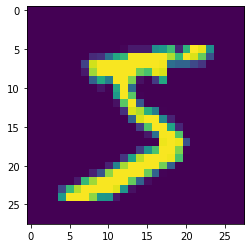

In [0]:
import matplotlib.pyplot as plt
#plot the first image in the dataset
plt.imshow(X_train[0])

In [0]:
X_train[0].shape

(28, 28)

In [0]:
#reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

In [0]:
from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

In [0]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 9s 156us/step - loss: 0.2891 - accuracy: 0.9508 - val_loss: 0.0981 - val_accuracy: 0.9708
Epoch 2/3
60000/60000 [==============================] - 9s 157us/step - loss: 0.0746 - accuracy: 0.9776 - val_loss: 0.0931 - val_accuracy: 0.9734
Epoch 3/3
60000/60000 [==============================] - 9s 155us/step - loss: 0.0510 - accuracy: 0.9842 - val_loss: 0.0921 - val_accuracy: 0.9734


In [0]:
X_train.shape

(60000, 28, 28, 1)

In [0]:
y_train.shape

(60000, 10)

In [0]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [0]:
old_image = np.ones((100,100,3))
new_image = np.ones((100,100,3,1))    

# lets jsut say you have two Images 
old_image = np.reshape(old_image , (100,100,3,1))
new_image = np.reshape(new_image , (100,100,3,1))
directory = np.append( new_image , old_image , axis = 3)

In [0]:
directory.shape

(100, 100, 3, 2)

In [0]:
n_samples = len(y_train)
print(n_samples)
Y_train = []
for i in range(n_samples):
  Y_train = np.append( Y_train , y_train[i+1]["array"])
  #Y_train = np.append(Y_train, y_train[i+1]["labels"].astype("int"))

X_train= X_train.reshape((1,448, 448, 3))
Y_train= Y_train.reshape((1,1,1,4))
Y_train = Y_train.astype("float32")
print(Y_train.shape)
print(Y_train)